In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

os.environ["QT_QPA_PLATFORM"] = "xcb"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 18

# Load data
data = np.load("psths.npz")
X, times = data["X"], data["times"]
total_num_conditions = 108
total_len_timebins = 130
total_num_neurons = 182

t0 = int((-150 - (-800)) / 10 + 1)
X_random_conditions = X.copy()
for i in range(total_num_neurons):
    conditions_to_keep = np.random.choice(
        total_num_conditions, (total_num_conditions // 2), replace=False
    )
    for j in conditions_to_keep:
        X_random_conditions[i][j][t0:] = X[i][j][t0] * 2 - X[i][j][t0:]

X = X_random_conditions

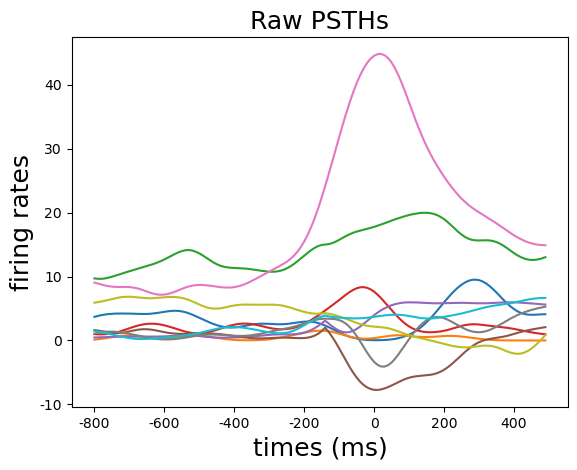

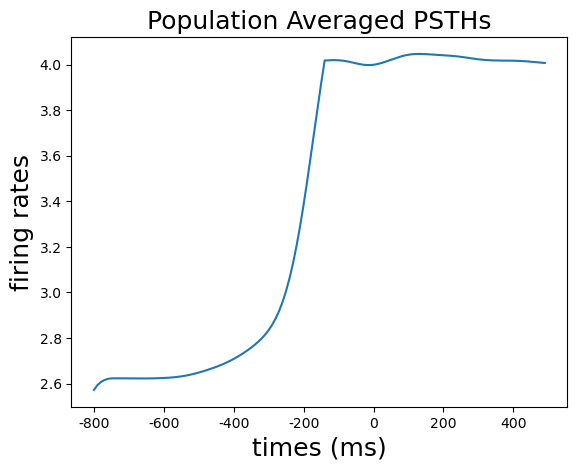

In [2]:
### 1. Plotting raw PSTHs
def plot_raw_psths(data, times, num_examples):
    """Plot the raw PSTH data for a few random traces.

    :param data: original neural data.
    :type data: numpy array
    :param times: times data in milliseconds.
    :type times: numpy array.
    :param num_examples: number of examples to plot.
    :type num_examples: integer
    """
    random_neurons_con = [
        (
            random.randint(1, total_num_neurons - 1),
            random.randint(1, total_num_conditions - 1),
        )
        for i in range(num_examples)
    ]

    for neurons_con_indices in random_neurons_con:
        plt.plot(times, data[neurons_con_indices[0], neurons_con_indices[1], :])

    plt.xlabel("times (ms)")
    plt.ylabel("firing rates")
    plt.title("Raw PSTHs")
    plt.show()


def plot_pop_avg(data, times):
    """Plot the population averaged data for a few random neurons and conditions.

    :param data: original neural data.
    :type data: numpy array
    :param times: times data in milliseconds.
    :type times: numpy array.
    """
    population_averaged_data = np.mean(np.mean(data, axis=0), axis=0)

    plt.plot(times, population_averaged_data)
    plt.xlabel("times (ms)")
    plt.ylabel("firing rates")
    plt.title("Population Averaged PSTHs")
    plt.show()


plot_raw_psths(X, times, 10)
plot_pop_avg(X, times)

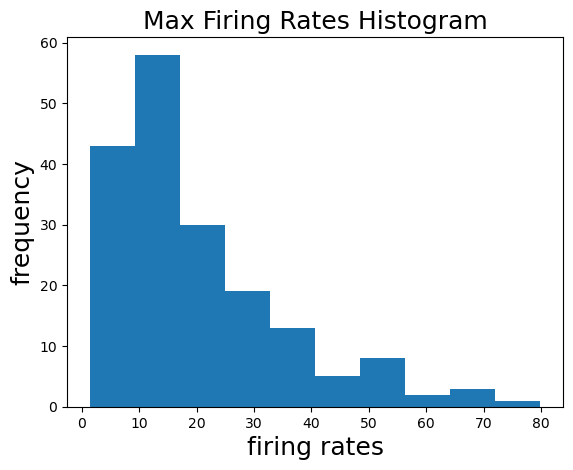

In [3]:
### 2.Preprocessing
# Get max and min firing rates for each neuron across time and conditions
max_firing_per_neuron = np.max(X, axis=(1, 2))
min_firing_per_neuron = np.min(X, axis=(1, 2))


# Plot the max firing rates
def plot_max_firing_rate(data, num_bins):
    """Plot the maximum firing rates of neurons across conditions and times.
    :param num_bins: number of bins for the histogram.
    :type num_bins: integer
    """
    max_firing_per_neuron = np.max(data, axis=(1, 2))

    plt.hist(max_firing_per_neuron, num_bins)
    plt.xlabel("firing rates")
    plt.ylabel("frequency")
    plt.title("Max Firing Rates Histogram")
    plt.show()


plot_max_firing_rate(X, 10)


# Normalise X
def normalise_firing_rates(X, a, b):
    """Normalise firing rates according to the formula given.

    :param X: Original PSTH.
    :type X: np array
    :param a: max of firing rate per neuron.
    :type a: np array
    :param b: min of firing rate per neuron.
    :type b: np array
    :return: Normalised PSTH.
    :rtype: numpy array.
    """
    for i in range(total_num_neurons):
        for j in range(total_num_conditions):
            for k in range(total_len_timebins):
                X[i, j, k] = (X[i, j, k] - b[i]) / (a[i] - b[i] + 5)
    return X


X_normalised = normalise_firing_rates(X, max_firing_per_neuron, min_firing_per_neuron)


# Mean-center X
def mean_center_x(data):
    for i in range(total_num_neurons):
        for j in range(total_num_conditions):
            for k in range(total_len_timebins):
                data[i, j, k] = data[i, j, k] - np.mean(data[i, :, k])
    return data


X_mean_centered = mean_center_x(X_normalised)

In [4]:
import scipy
from sklearn.decomposition import PCA


# Limit X to time bins from -150ms to 300ms
start_time = int((-150 - (-800)) / 10)
end_time = int((300 - (-800)) / 10 + 1)
X_shorter_time = X_mean_centered[:, :, start_time:end_time]
new_total_num_timebins = X_shorter_time.shape[2]

reshaped_X_shorter_time = X_shorter_time.reshape(total_num_neurons, -1)


def dimensionality_reduction(X, num_dimensions):
    """Perfrom PCA on the data matrix X.

    :param X: input data (reshapted to 2D here).
    :type X: numpy array
    :param num_dimensions: num_dimensions to keep for PCA.
    :type num_dimensions: integer
    :return: eigenvalues, V_m matrix and final data with dimensionality reduced.
    :rtype: numpy array, numpy array, numpy array
    """
    N, T = X.shape[0], X.shape[1]
    # Calculate the sample covariance matrix
    S_hat = (X @ np.transpose(X)) / T

    # Get first num_dimensions eigenvectors of S_hat to form V_M matrix
    e_values, e_vectors = scipy.linalg.eig(S_hat)
    e_values = e_values[0:num_dimensions]
    V_m = e_vectors[:, 0:num_dimensions]

    # V_m should be of size (182 * 12), Z should be of size (12 * 4968)

    # Project onto V_m space
    Z = np.transpose(V_m) @ X
    return e_values, V_m, Z


num_dimensions = 12
e_values, V_m, Z = dimensionality_reduction(reshaped_X_shorter_time, num_dimensions)

In [5]:
from matplotlib.colors import LinearSegmentedColormap

black_c = lambda c: LinearSegmentedColormap.from_list("BlkGrn", [(0, 0, 0), c], N=256)


def get_colors(xs, ys, alt_colors=False):
    """
    returns a list of colors (that can be passed as the optional "color" or "c" input arguments to Matplotlib plotting functions)
    based on the values in the coordinate lists (or 1D array) xs and ys. More specifically, colors are based on the
    projected location along a direction with the widest spread of points.
    :param xs, ys: two vectors (lists or 1D arrays of the same length) containing the x and y coordinates of a set of points
    :param alt_colors: if True, the green and red color poles (for negative and positive values) are switched to cyan and magenta.
    :return:
    colors: a list (with same length as xs) of colors corresponding to coorinates along the maximum-spread direction:
    small values are closer to black, large positive values closer to red, and large negative values closer to green.
    The elements of "colors" can be passed as the optional "color" or "c" input argument to Matplotlib plotting functions.
    """
    xys = np.array([xs, ys])
    u, _, _ = np.linalg.svd(xys)
    normalize = lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1
    xs = normalize(u[:, 0].T @ xys)
    if alt_colors:
        pos_cmap = black_c((1, 0, 1))
        neg_cmap = black_c((0, 1, 1))
    else:
        pos_cmap = black_c((1, 0, 0))
        neg_cmap = black_c((0, 1, 0))

    colors = []
    for x in xs:
        if x < 0:
            colors.append(neg_cmap(-x))
        else:
            colors.append(pos_cmap(+x))

    return colors


def plot_start(xs, ys, colors, markersize=500, ax=None, alpha=1.0):
    """
    Puts round markers on the starting point of trajectories
    :param xs: x-coordinates of the initial point of trajectories
    :param ys: y-coordinates of the initial point of trajectories
    :param colors: colors for different conditions obtained using the get_colors function
    :param markersize: size of the markers
    :param ax: axis on which to plot (optional)
    :param alpha: how transparent the points are.
    """
    if ax is None:
        plt.scatter(
            xs, ys, s=markersize, color=colors, marker=".", edgecolors="k", alpha=alpha
        )
    else:
        ax.scatter(
            xs, ys, s=markersize, color=colors, marker=".", edgecolors="k", alpha=alpha
        )


def plot_end(xs, ys, colors, markersize=100, ax=None, alpha=1.0):
    """
    Puts diamond-shaped markers on the end point of trajectories
    :param xs: x-coordinates of the final point of trajectories
    :param ys: y-coordinates of the final point of trajectories
    :param colors: colors for different conditions obtained using the get_colors function
    :param markersize: size of the markers
    :param ax: axis on which to plot (optional)
    :param alpha: how transparent the points are.
    """
    if ax is None:
        plt.scatter(
            xs, ys, s=markersize, color=colors, marker="D", edgecolors="k", alpha=alpha
        )
    else:
        ax.scatter(
            xs, ys, s=markersize, color=colors, marker="D", edgecolors="k", alpha=alpha
        )

(108, 46)


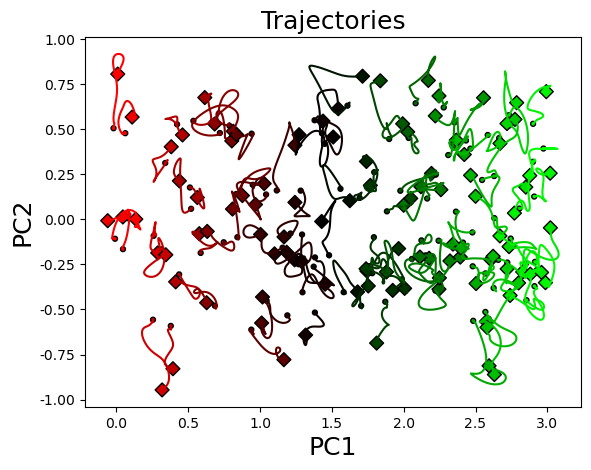

In [6]:
### 3. Plotting PC space trajectories
import numpy as np

# Get the 0 and 1 left indices of Z
Z_first_two = Z[:2, :]
# Reshape back to 3D array
Z_first_two_3D = Z_first_two.reshape(2, total_num_conditions, -1)


def plot_first_two_PCs(data):
    """Plot the data in PC1 and PC2 trajectories.

    :param data: normalised, mean-centered, lower-dimensional, PC1 and PC2 of data (Z).
    :type data: numpy array
    """

    PC1_arrays = data[0, :, :]
    print(PC1_arrays.shape)
    PC2_arrays = data[1, :, :]
    # Get start and end x and y positions
    start_xs = PC1_arrays[:, 0]
    start_ys = PC2_arrays[:, 0]
    end_xs = PC1_arrays[:, -1]
    end_ys = PC2_arrays[:, -1]
    # Get colors
    colors = get_colors(start_xs, start_ys)

    # Plot for all conditions
    for i in range(total_num_conditions):
        PC1_array = PC1_arrays[i, :]
        PC2_array = PC2_arrays[i, :]
        plt.plot(PC1_array, PC2_array, color=colors[i])

    # Plot start and end points
    plot_start(start_xs, start_ys, colors, markersize=50)
    plot_end(end_xs, end_ys, colors, markersize=50)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Trajectories")
    plt.show("3_PC_traj")
    plt.show()


plot_first_two_PCs(Z_first_two_3D)

In [7]:
### 4. Find the ML estimate for A
Z_3D = Z.reshape(num_dimensions, total_num_conditions, -1)


# Construct 3D array H to associate beta with A
def construct_H(num_dimensions):
    """Construct tensor H according to the specification shown when row-array convention is followed.

    :param num_dimensions: dimension of A.
    :type num_dimensions: integer
    :return: H matrix.
    :rtype: numpy array
    """
    # Get the number of elements to fill.
    K = int(num_dimensions * (num_dimensions - 1) / 2)
    H = np.zeros((K, num_dimensions, num_dimensions))
    counter = 0
    for i in range(num_dimensions):
        for j in range(num_dimensions):
            if j > i:
                H[counter][i][j] = 1
                H[counter][j][i] = -1
                counter += 1

    return H


def get_A(beta, H, num_dimensions):
    """Get the A matrix using beta and the number of dimensions

    :param beta: K-dimensional vectgor containing entries for A.
    :type beta: np array
    :param H: H matrix as in notes.
    :type H: numpy array
    :param num_dimensions: dimension of A.
    :type num_dimensions: integer
    :return: A matrix.
    :rtype: numpy array
    """
    A = np.tensordot(beta, H, axes=([0], [0]))

    return A


test_beta = [2, 3, 4, 9, 10, 45]
test_H = construct_H(int(4))
test_A = get_A(test_beta, test_H, int(4))
print(test_A)

[[  0.   2.   3.   4.]
 [ -2.   0.   9.  10.]
 [ -3.  -9.   0.  45.]
 [ -4. -10. -45.   0.]]


In [8]:
import numpy as np

test_Z = np.load("test.npz")

with np.load("test.npz") as test_data:
    test_Z = test_data["Z_test"]
    test_A = test_data["A_test"]

In [9]:
def get_ML_A(Z_3D):
    """Get the ML estimate for A.

    :param Z_3D: Original Z matrix, which is 3D.
    :type Z_3D: numpu array
    :return: beta array and optimal A matrix.
    :rtype: numpy array, numpy array
    """
    # Get Delta Z
    Delta_Z_3D = Z_3D[:, :, 1:] - Z_3D[:, :, :-1]

    print("Finished calculating delta Z!")

    H = construct_H(num_dimensions)
    print("Finished getting H!")
    Z_3D_truncated = Z_3D[:, :, :-1]

    # Formulate gamma
    print("Start getting gamma")
    Q = np.tensordot(Delta_Z_3D, Z_3D_truncated, axes=([1, 2], [1, 2]))
    gamma = np.tensordot(Q, H, axes=([0, 1], [1, 2]))

    # Formulate M
    print("Start getting M")
    R = np.tensordot(Z_3D_truncated, Z_3D_truncated, axes=([1, 2], [1, 2]))
    N = np.tensordot(H, R, axes=([2], [0]))
    M = np.tensordot(N, H, axes=([1, 2], [1, 2]))

    # Get beta
    print("Start calculating beta")
    beta = np.linalg.solve(M, gamma)

    # Get A
    print("Start calculating A")
    A = get_A(beta, H, num_dimensions)
    return beta, A


# _, estimated_A = get_ML_A(test_Z)

Finished calculating delta Z!
Finished getting H!
Start getting gamma
Start getting M
Start calculating beta
Start calculating A


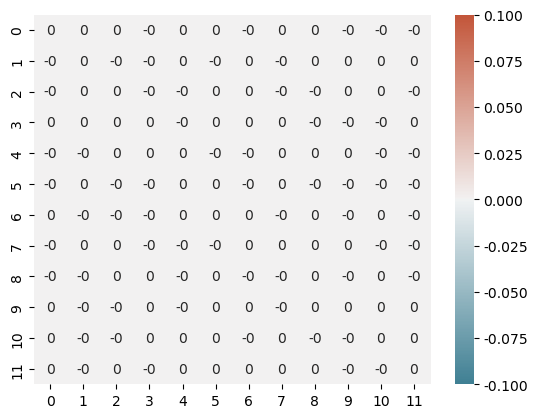

In [10]:
# plot_end(end_xs, end_ys, colors, markersize=50)
# # From the test
# error = np.amax(test_A - estimated_A)
# print(error)


# From the actual Z
_, estimated_A = get_ML_A(Z_3D)


# Make a colorplot of A
def colorplot(matrix):
    """Create a colorplot of matrix A.

    :param matrix: Matrix to be plotted.
    :type matrix: numpy array
    """
    # Round to 2 floating point numbers
    matrix = np.around(matrix, 2)
    # Choose binary colormap
    cm = sns.diverging_palette(220, 20, as_cmap=True)
    x = pd.DataFrame(matrix)
    heatplot = sns.heatmap(x, cmap=cm, annot=True)
    fig = heatplot.get_figure()


colorplot(estimated_A)

In [11]:
### 5. 2D projections with rotataional dynamics
import scipy

e_values, e_vectors = scipy.linalg.eig(estimated_A)
print(e_values)
print(e_vectors)

[ 2.58381299e-20+5.48601837e-03j  2.58381299e-20-5.48601837e-03j
 -5.14553006e-20+3.51722047e-03j -5.14553006e-20-3.51722047e-03j
  1.06654899e-19+2.83935249e-03j  1.06654899e-19-2.83935249e-03j
 -3.14380040e-19+1.26999084e-03j -3.14380040e-19-1.26999084e-03j
 -5.51631499e-20+5.10037792e-04j -5.51631499e-20-5.10037792e-04j
 -2.06184300e-20+1.31495297e-05j -2.06184300e-20-1.31495297e-05j]
[[ 0.01347743-0.00658651j  0.01347743+0.00658651j -0.05087944+0.02289093j
  -0.05087944-0.02289093j  0.00352783-0.00985424j  0.00352783+0.00985424j
   0.0314963 +0.03157196j  0.0314963 -0.03157196j -0.03887962-0.01827105j
  -0.03887962+0.01827105j  0.70193906+0.j          0.70193906-0.j        ]
 [ 0.04533883+0.06725846j  0.04533883-0.06725846j  0.34733942-0.11556887j
   0.34733942+0.11556887j -0.0759345 -0.31585967j -0.0759345 +0.31585967j
  -0.23767402-0.00518888j -0.23767402+0.00518888j  0.07887769-0.43555924j
   0.07887769+0.43555924j  0.02858292+0.02490151j  0.02858292-0.02490151j]
 [-0.04574615+0

In [12]:
def get_P_matrix(e_vectors, index):
    """Get the P matrix as specified in the notes from the eigenvector corresponding to the indexth eigenvalue.

    :param e_vectors: all eigenvectors.
    :type e_vectors: numpy array
    :param index: which eigenvalue to use.
    :type index: integer
    :return: P matrix.
    :rtype: numpy array
    """
    # Remember that complex conjugate pairs are together, hence we need to skip 2.
    largest_e_vector = e_vectors[:, int(index * 2)]

    real_e_vector = np.array([e.real for e in largest_e_vector])
    normalised_real_e_vector = real_e_vector / np.linalg.norm(real_e_vector)
    imag_e_vector = np.array([e.imag for e in largest_e_vector])
    normalised_imag_e_vector = imag_e_vector / np.linalg.norm(imag_e_vector)
    P = np.stack((normalised_real_e_vector, normalised_imag_e_vector), axis=0)
    return P


# Plot P_FR trajectories from [-150, 200]
start_time_five = 0
end_time_five = int((200 - (-150)) / 10 + 1)


def plot_2D_trajectories(Z_projected_P, title):
    """Plot the data in FR plane.

    :param Z_projected_P: data projected on to the rotation plane.
    :type Z_projected_P: numpy array
    :param title: title of the plot.
    :type string
    """

    # Get 3D version of P_FR, truncated to the appropriate time
    Z_projected_P_3D = Z_projected_P.reshape(2, total_num_conditions, -1)
    Z_projected_P_3D_shorter_time = Z_projected_P_3D[
        :, :, start_time_five:end_time_five
    ]

    PC1_arrays = Z_projected_P_3D_shorter_time[0, :, :]
    PC2_arrays = Z_projected_P_3D_shorter_time[1, :, :]
    # Get start and end x and y positions
    start_xs = PC1_arrays[:, 0]
    start_ys = PC2_arrays[:, 0]
    end_xs = PC1_arrays[:, -1]
    end_ys = PC2_arrays[:, -1]
    # Get colors
    colors = get_colors(start_xs, start_ys)

    # Plot for all conditions
    for i in range(total_num_conditions):
        PC1_array = PC1_arrays[i, :]
        PC2_array = PC2_arrays[i, :]
        plt.plot(PC1_array, PC2_array, color=colors[i])

    # # Plot start and end points
    plot_start(start_xs, start_ys, colors, markersize=50)
    plot_end(end_xs, end_ys, colors, markersize=50)
    plt.xlabel("Real Eigenvector")
    plt.ylabel("Imaginary Eigenvector")
    plt.title(title)
    plt.savefig("7_distort.png")
    plt.show()

(2, 12)


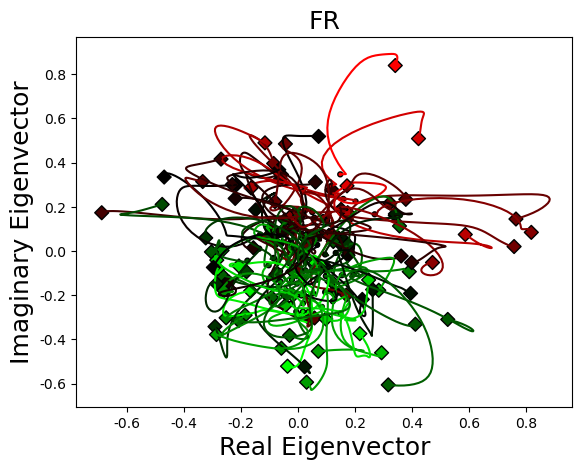

In [13]:
# P_largest is P_FR in the notes
P_largest = get_P_matrix(e_vectors, 0)
print(P_largest.shape)

# Apply P to Z to obtain the 2D projection
Z_projected_P = P_largest @ Z


plot_2D_trajectories(Z_projected_P, "FR")